# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
## Your code here
from collections import Counter
import numpy as np

drop_out_threshold = 1e-5
import random

cnt = Counter()
for int_word in int_words:
    cnt[int_word] += 1
total_count = len(int_words)
train_words = []

for int_word in int_words:
    drop_out_probobality = 1 - np.sqrt(drop_out_threshold/(cnt[int_word]/total_count))
    if not (drop_out_probobality > random.random() and drop_out_probobality > 0):
        train_words.append(int_word)
        
        



# = # The final subsampled word list

print(int_words[0:20])
print(train_words[0:20])

print(len(int_words))
print(len(train_words))

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102]
[5233, 3133, 155, 476, 10571, 27349, 15067, 58112, 10712, 214, 1324, 362, 686, 7088, 247, 5233, 248, 44611, 186, 200]
16680599
4628044


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [9]:
n_vocab = len(int_to_vocab)
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [10]:

n_embedding = 300# Number of embedding features 
with train_graph.as_default():
    embedding =tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))# create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, inputs)# use tf.nn.embedding_lookup to get the hidden layer output

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal([n_vocab, n_embedding]))# create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros([n_vocab]))# create softmax biases here
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [12]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [13]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [14]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 21.7129 0.0433 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 21.5275 0.0292 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 21.1513 0.0297 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 21.1595 0.0295 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 20.9291 0.0291 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 20.8023 0.0301 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 20.7389 0.0313 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 20.6309 0.0288 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 20.4437 0.0289 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 20.2697 0.0289 sec/batch
Nearest to but: paraffin, whistling, tuples, seduce, initiatives, curtailed, bodley, colones,
Nearest to zero: strangest, interacting, servings, sanchez, highbury, sergeant, elmira, crass,
Nearest to with: disloyalty, trofim, longmans, ullmann, unsubstantiated, alhazen, moab, canonicity,


Nearest to or: to, is, of, the, and, as, in, that,
Nearest to first: s, three, nine, eight, two, but, and, to,
Nearest to pre: absolutive, nei, coils, nymphet, cadoc, capitan, munition, ftl,
Nearest to something: contractus, constrain, inhabits, berthe, selwyn, complexity, affirms, prosecutions,
Nearest to versions: moonset, janitor, kona, regnant, explainable, infix, deals, disappointed,
Nearest to issue: agency, overkill, df, cover, lymphomas, realities, addington, dubai,
Nearest to writers: scripts, following, eradicating, busses, seam, lydian, deadliest, maybach,
Nearest to operations: eagle, universitaria, insufflated, depress, sail, peroxide, alameda, savanna,
Nearest to experience: distrust, interferon, stroud, stagnating, sugary, ke, page, swept,
Nearest to active: ahura, monotone, alpes, upgrading, citeseer, predicting, lonesome, stationing,
Epoch 2/10 Iteration: 8100 Avg. Training loss: 13.5353 0.0299 sec/batch
Epoch 2/10 Iteration: 8200 Avg. Training loss: 13.6677 0.0286 sec

Nearest to that: be, is, not, a, to, this, it, in,
Nearest to by: the, of, in, and, a, to, on, as,
Nearest to may: are, or, is, that, to, the, be, a,
Nearest to or: is, not, be, a, are, to, this, often,
Nearest to first: in, of, the, and, a, on, to, was,
Nearest to pre: the, found, of, were, been, was, from, since,
Nearest to something: that, be, not, is, or, this, do, but,
Nearest to versions: version, available, is, standard, can, it, to, original,
Nearest to issue: another, to, this, the, which, of, a, in,
Nearest to writers: events, old, named, history, view, great, notable, english,
Nearest to operations: since, addition, long, significant, which, by, such, on,
Nearest to experience: likely, own, not, should, it, whether, different, already,
Nearest to active: a, that, they, to, various, so, have, of,
Epoch 4/10 Iteration: 17100 Avg. Training loss: 8.9146 0.0303 sec/batch
Epoch 4/10 Iteration: 17200 Avg. Training loss: 8.4859 0.0288 sec/batch
Epoch 4/10 Iteration: 17300 Avg. Train

Epoch 6/10 Iteration: 26100 Avg. Training loss: 6.4850 0.0302 sec/batch
Epoch 6/10 Iteration: 26200 Avg. Training loss: 6.5686 0.0289 sec/batch
Epoch 6/10 Iteration: 26300 Avg. Training loss: 6.6034 0.0289 sec/batch
Epoch 6/10 Iteration: 26400 Avg. Training loss: 6.4564 0.0288 sec/batch
Epoch 6/10 Iteration: 26500 Avg. Training loss: 6.4092 0.0289 sec/batch
Epoch 6/10 Iteration: 26600 Avg. Training loss: 6.4000 0.0288 sec/batch
Epoch 6/10 Iteration: 26700 Avg. Training loss: 6.6266 0.0292 sec/batch
Epoch 6/10 Iteration: 26800 Avg. Training loss: 6.5231 0.0290 sec/batch
Epoch 6/10 Iteration: 26900 Avg. Training loss: 6.6421 0.0288 sec/batch
Epoch 6/10 Iteration: 27000 Avg. Training loss: 6.7337 0.0289 sec/batch
Nearest to but: it, that, not, to, they, have, a, their,
Nearest to zero: two, three, five, seven, four, one, eight, six,
Nearest to with: the, a, in, of, to, and, for, as,
Nearest to that: have, this, not, as, they, a, to, which,
Nearest to by: the, of, in, to, and, for, a, s,
N

Epoch 8/10 Iteration: 35300 Avg. Training loss: 5.5105 0.0289 sec/batch
Epoch 8/10 Iteration: 35400 Avg. Training loss: 5.5312 0.0290 sec/batch
Epoch 8/10 Iteration: 35500 Avg. Training loss: 5.5035 0.0288 sec/batch
Epoch 8/10 Iteration: 35600 Avg. Training loss: 5.5491 0.0289 sec/batch
Epoch 8/10 Iteration: 35700 Avg. Training loss: 5.3055 0.0289 sec/batch
Epoch 8/10 Iteration: 35800 Avg. Training loss: 5.3845 0.0288 sec/batch
Epoch 8/10 Iteration: 35900 Avg. Training loss: 5.4184 0.0291 sec/batch
Epoch 8/10 Iteration: 36000 Avg. Training loss: 5.4710 0.0290 sec/batch
Nearest to but: it, that, as, they, to, a, being, could,
Nearest to zero: two, three, four, five, seven, one, eight, nine,
Nearest to with: the, as, to, and, it, a, in, but,
Nearest to that: have, this, be, not, to, as, only, it,
Nearest to by: the, as, of, and, to, a, for, in,
Nearest to may: not, term, it, have, that, is, as, some,
Nearest to or: usually, these, are, example, used, such, some, can,
Nearest to first: th

Nearest to experience: thinking, because, feeling, focus, not, what, do, yet,
Nearest to active: such, other, and, for, activity, include, major, which,
Epoch 10/10 Iteration: 44100 Avg. Training loss: 4.9645 0.0302 sec/batch
Epoch 10/10 Iteration: 44200 Avg. Training loss: 5.0321 0.0288 sec/batch
Epoch 10/10 Iteration: 44300 Avg. Training loss: 4.8301 0.0289 sec/batch
Epoch 10/10 Iteration: 44400 Avg. Training loss: 4.9453 0.0289 sec/batch
Epoch 10/10 Iteration: 44500 Avg. Training loss: 5.0075 0.0288 sec/batch
Epoch 10/10 Iteration: 44600 Avg. Training loss: 4.8487 0.0289 sec/batch
Epoch 10/10 Iteration: 44700 Avg. Training loss: 4.8856 0.0288 sec/batch
Epoch 10/10 Iteration: 44800 Avg. Training loss: 4.9140 0.0290 sec/batch
Epoch 10/10 Iteration: 44900 Avg. Training loss: 4.8546 0.0289 sec/batch
Epoch 10/10 Iteration: 45000 Avg. Training loss: 4.7716 0.0288 sec/batch
Nearest to but: to, it, that, a, being, be, the, this,
Nearest to zero: two, five, three, six, one, eight, four, nine

Restore the trained network if you need to:

In [15]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

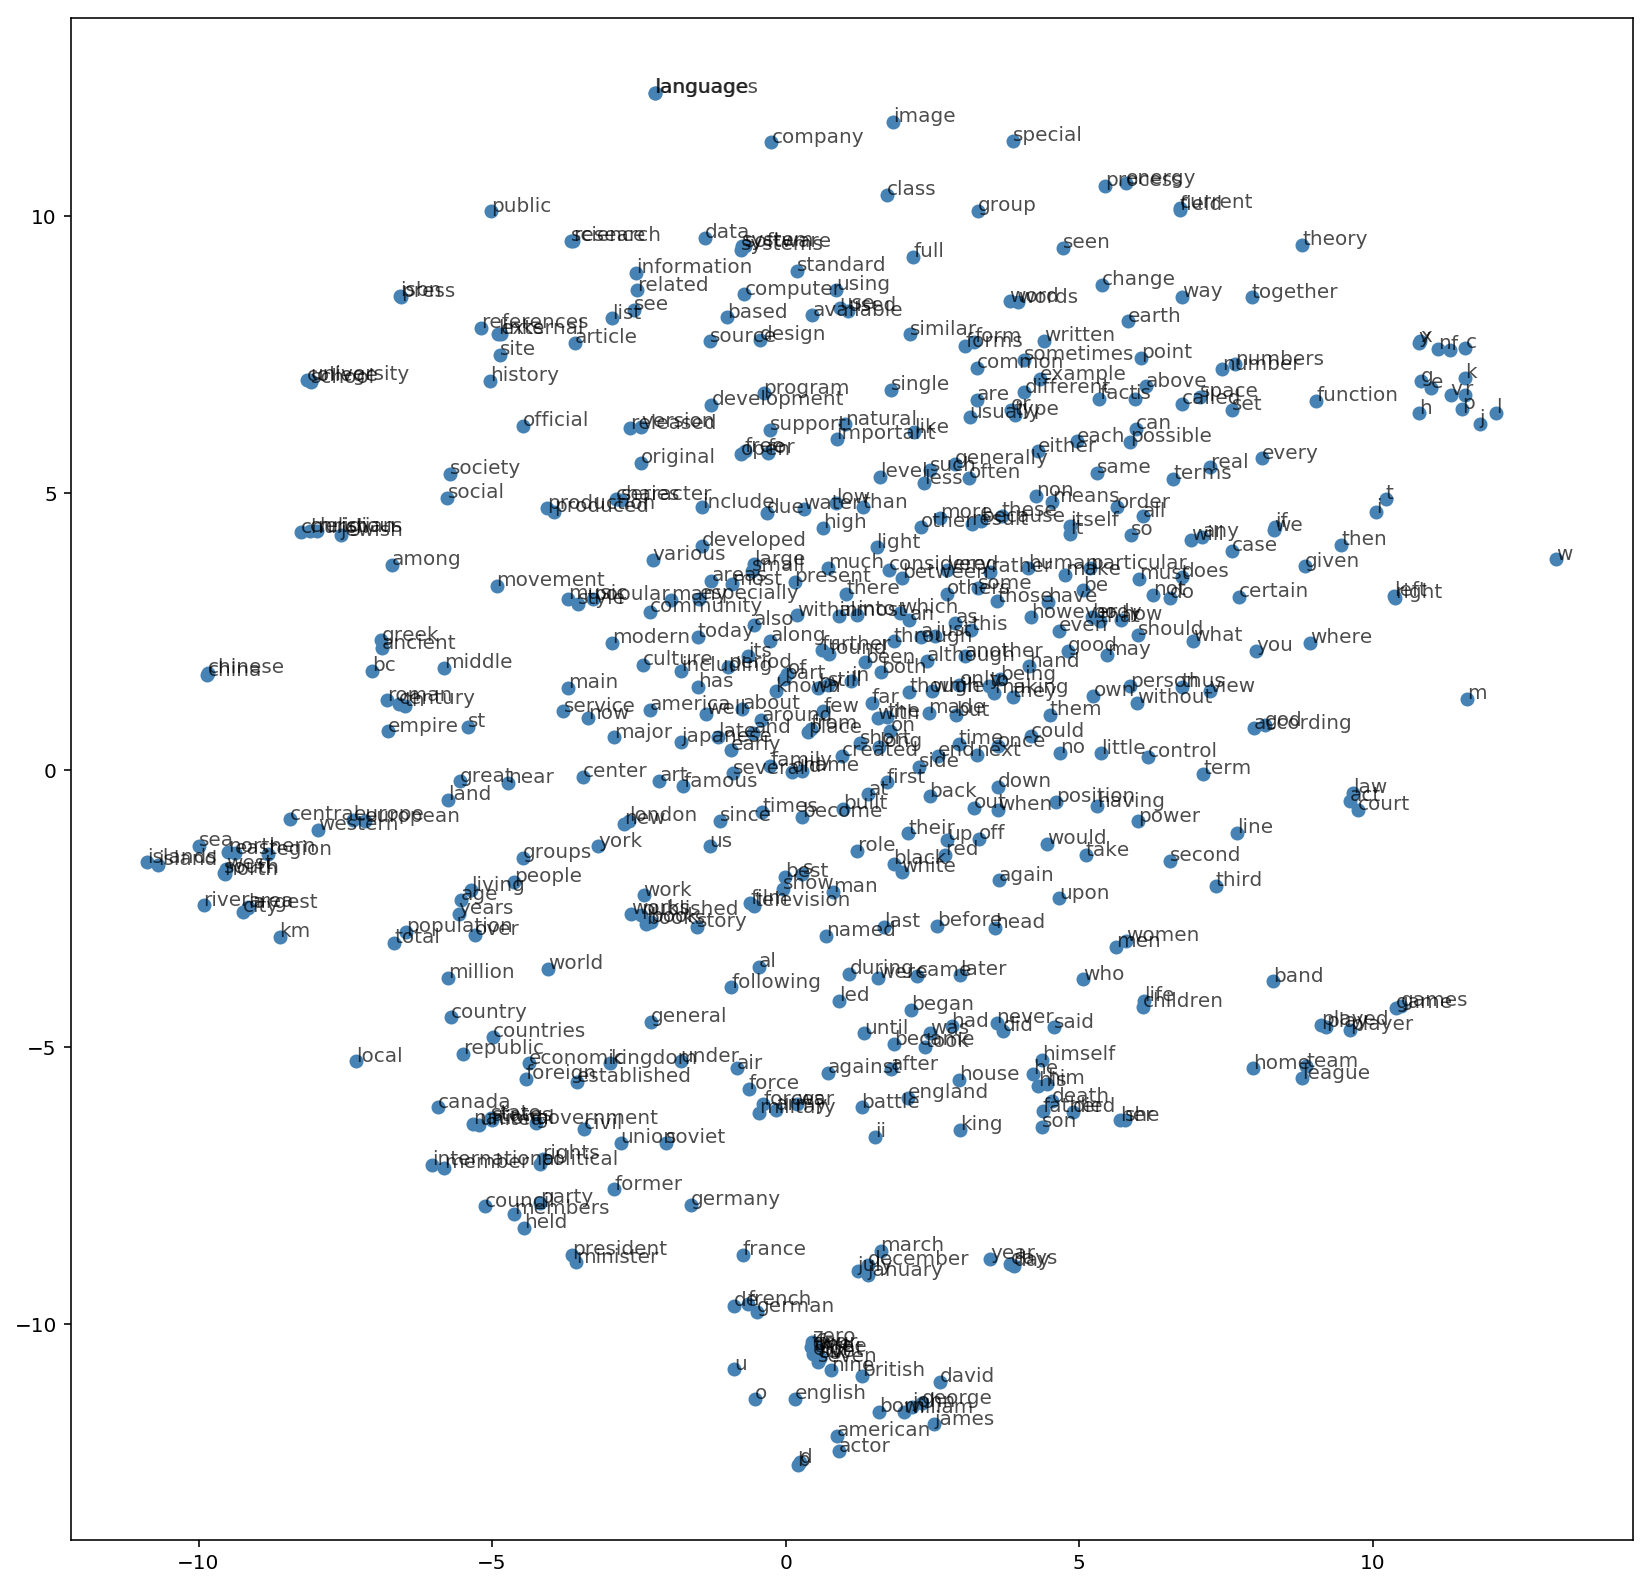

In [18]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)